In [1]:
import pandas as pd
import numpy as np
import time
import re
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

In [2]:
# Viewing settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# Filters
DC_filter = ['cummings']
MC_filter = ['matthancock', 'matt hancock']

In [4]:
def filter_data(data, filters = MC_filter):
    #Function to filter the weekly data to UK tweets only
    
    #First filter by language to english only
    data = data.loc[data['lang'].str.contains('en', na=False)]
    print("there are ", len(data), "english tweets")
    
    #Next filter by dominic cummings/matt hancock related tweets using the keywords list
    data = data.loc[data['text'].str.contains('|'.join(filters), na=False)]
    
    #Reset index
    data.reset_index(drop=True, inplace=True)
    
    return data

# Now performing the actual filtering, language filtered by english and user.location based on a list of cities/country names defined from UK Cities List

## Loading the data

In [5]:
this_data = pd.read_pickle('/Users/brandon/Documents/UCL/Project/COVID Project/Data/MC_Data_Week_2')
this_data.head(5)

,created_at,lang,text,user.location
3245342,2021-07-04 00:00:00+00:00,es,"RT @signofthewxlls: hola de nuevoo, soy martu/tinchu. tengo 15 y soy de argentina,, staneo a louis y harry desde 2017 más o menos. just lik…",mirando skins con giu
3245343,2021-07-04 00:00:00+00:00,en,"""Stage Training | Fear of Speaking in Singapore Now Due to Corona Virus Outbreak""\n\nWatch Now: https://t.co/5tOm0u8gwP",Singapore
3245344,2021-07-04 00:00:00+00:00,es,Capacitación | Soporte técnico | Licencias \nEmilio Carranza #875 Esquina Ramon Corona c.p.25000\n{844} 4104070 - 41… https://t.co/CeNiWdi27y,"Saltillo, Coahuila"
3245345,2021-07-04 00:00:00+00:00,es,"¡Hola!, solo un recordatorio de que ya falta una hora menos para que Piñera se vaya del gobierno 😉. Para ser exacto… https://t.co/m6MjaCQRAQ","Santiago, Chile"
3245346,2021-07-04 00:00:00+00:00,en,RT @davidlparsons: We ran out of prison slaves to put out the climate change wildfires because of the pandemic https://t.co/gBVrAUmzJk,NaN


In [6]:
print(len(this_data))

7098688


## Filtering the data

In [7]:
this_data = filter_data(this_data)
this_data.head(5)

there are  4731193 english tweets


,created_at,lang,text,user.location
0,2021-07-04 02:36:53+00:00,en,RT @inelliegant: matt hancock's next job could be in cyber (he just doesn't know it yet),NaN
1,2021-07-04 07:19:38+00:00,en,"@Lord_Sugar Glad to see someone agrees Liz, matt hancock. Was Good at rolling words off his tongue, he didn't have… https://t.co/Wowa6JVe3s","Plymouth, England"
2,2021-07-04 09:06:09+00:00,en,@sajidjavid I see we got an upgrade over matt hancock 🤓,NaN
3,2021-07-04 10:17:28+00:00,en,Lols 😆 #socialdistance #hancock #memes #matthancock #thewhitecross #londonbylondoners #richmond #summerinlondon… https://t.co/f8lXp90ZMd,London
4,2021-07-04 11:04:21+00:00,en,"RT @hassxn7: if matt hancock can get 2 women, maybe i won't die single after all.",17yrs of denying my existence


In [8]:
print(len(this_data))

115


## Clean Tweets for Sentiment Analysis

In [9]:
def remove_pattern(input_txt, pattern):
    """Function to help remove tweet specific patterns"""
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

In [10]:
def clean_tweets(tweets):
    """Function to clean tweets specifically as they contain certain patterns and formats different to a normal sentence"""
    #remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    
    #remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    
    #remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    
    #remove special characters, numbers, punctuations (except for #)
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    
    return tweets

In [11]:
#Cleaning the tweets
this_data['clean_tweet'] = clean_tweets(this_data['text'])
this_data.head(10)

,created_at,lang,text,user.location,clean_tweet
0,2021-07-04 02:36:53+00:00,en,RT @inelliegant: matt hancock's next job could be in cyber (he just doesn't know it yet),NaN,matt hancock's next job could be in cyber (he just doesn't know it yet)
1,2021-07-04 07:19:38+00:00,en,"@Lord_Sugar Glad to see someone agrees Liz, matt hancock. Was Good at rolling words off his tongue, he didn't have… https://t.co/Wowa6JVe3s","Plymouth, England","Glad to see someone agrees Liz, matt hancock. Was Good at rolling words off his tongue, he didn't have…"
2,2021-07-04 09:06:09+00:00,en,@sajidjavid I see we got an upgrade over matt hancock 🤓,NaN,I see we got an upgrade over matt hancock 🤓
3,2021-07-04 10:17:28+00:00,en,Lols 😆 #socialdistance #hancock #memes #matthancock #thewhitecross #londonbylondoners #richmond #summerinlondon… https://t.co/f8lXp90ZMd,London,Lols 😆 #socialdistance #hancock #memes #matthancock #thewhitecross #londonbylondoners #richmond #summerinlondon…
4,2021-07-04 11:04:21+00:00,en,"RT @hassxn7: if matt hancock can get 2 women, maybe i won't die single after all.",17yrs of denying my existence,"if matt hancock can get 2 women, maybe i won't die single after all."
5,2021-07-04 13:58:57+00:00,en,RT @dandouglas: thinking about reinstalling duke nukem 3D to recreate matt hancock’s office in the build engine featuring a working securit…,UK,thinking about reinstalling duke nukem 3D to recreate matt hancock’s office in the build engine featuring a working securit…
6,2021-07-04 14:17:25+00:00,en,"Me: mum, can I have matt hancock?\n\nMum: we have matt hancock at home\n\nThe matt hancock at home:","Gammonville, Normal Island","Me: mum, can I have matt hancock?\n\nMum: we have matt hancock at home\n\nThe matt hancock at home:"
7,2021-07-04 16:49:12+00:00,en,RT @CamillaTominey: The flailing PM has lost touch with the British public... my column this week #matthancock #covid #Lockdown #BatleyAndS…,London,The flailing PM has lost touch with the British public... my column this week #matthancock #covid #Lockdown #BatleyAndS…
8,2021-07-04 16:49:35+00:00,en,RT @Jimlong26: @johnredwood Maybe you should ask your government about this and matt hancock about midzallan he ordered from france .. in v…,North East Uk,Maybe you should ask your government about this and matt hancock about midzallan he ordered from france .. in v…
9,2021-07-04 19:37:10+00:00,en,@PoliticsForAlI I should think so too after matt hancock's little hoo har!!,ℓση∂ση,I should think so too after matt hancock's little hoo har!!


In [12]:
#Compute sentiments
analyser = SentimentIntensityAnalyzer()
scores = []

for i in range(this_data['clean_tweet'].shape[0]):
    print(i)
    compound = analyser.polarity_scores(this_data['clean_tweet'][i])["compound"]
    pos = analyser.polarity_scores(this_data['clean_tweet'][i])["pos"]
    neu = analyser.polarity_scores(this_data['clean_tweet'][i])["neu"]
    neg = analyser.polarity_scores(this_data['clean_tweet'][i])["neg"]
    
    if compound >= 0.05:
        senti = 'positive'
    elif compound <= -0.05:
        senti = 'negative'
    else:
        senti = 'neutral'
    
    scores.append({"Compound": compound,
                       "Positive": pos,
                       "Negative": neg,
                       "Neutral": neu,
                       "Sentiment": senti
                  })

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114


In [13]:
#Add to dataframe
sentiments_score = pd.DataFrame.from_dict(scores)
this_data = this_data.join(sentiments_score)
this_data.head(10)

,created_at,lang,text,user.location,clean_tweet,Compound,Positive,Negative,Neutral,Sentiment
0,2021-07-04 02:36:53+00:00,en,RT @inelliegant: matt hancock's next job could be in cyber (he just doesn't know it yet),NaN,matt hancock's next job could be in cyber (he just doesn't know it yet),0.0000,0.000,0.000,1.000,neutral
1,2021-07-04 07:19:38+00:00,en,"@Lord_Sugar Glad to see someone agrees Liz, matt hancock. Was Good at rolling words off his tongue, he didn't have… https://t.co/Wowa6JVe3s","Plymouth, England","Glad to see someone agrees Liz, matt hancock. Was Good at rolling words off his tongue, he didn't have…",0.7717,0.325,0.000,0.675,positive
2,2021-07-04 09:06:09+00:00,en,@sajidjavid I see we got an upgrade over matt hancock 🤓,NaN,I see we got an upgrade over matt hancock 🤓,-0.2960,0.000,0.180,0.820,negative
3,2021-07-04 10:17:28+00:00,en,Lols 😆 #socialdistance #hancock #memes #matthancock #thewhitecross #londonbylondoners #richmond #summerinlondon… https://t.co/f8lXp90ZMd,London,Lols 😆 #socialdistance #hancock #memes #matthancock #thewhitecross #londonbylondoners #richmond #summerinlondon…,0.3612,0.185,0.000,0.815,positive
4,2021-07-04 11:04:21+00:00,en,"RT @hassxn7: if matt hancock can get 2 women, maybe i won't die single after all.",17yrs of denying my existence,"if matt hancock can get 2 women, maybe i won't die single after all.",0.4847,0.195,0.000,0.805,positive
5,2021-07-04 13:58:57+00:00,en,RT @dandouglas: thinking about reinstalling duke nukem 3D to recreate matt hancock’s office in the build engine featuring a working securit…,UK,thinking about reinstalling duke nukem 3D to recreate matt hancock’s office in the build engine featuring a working securit…,0.0000,0.000,0.000,1.000,neutral
6,2021-07-04 14:17:25+00:00,en,"Me: mum, can I have matt hancock?\n\nMum: we have matt hancock at home\n\nThe matt hancock at home:","Gammonville, Normal Island","Me: mum, can I have matt hancock?\n\nMum: we have matt hancock at home\n\nThe matt hancock at home:",0.0000,0.000,0.000,1.000,neutral
7,2021-07-04 16:49:12+00:00,en,RT @CamillaTominey: The flailing PM has lost touch with the British public... my column this week #matthancock #covid #Lockdown #BatleyAndS…,London,The flailing PM has lost touch with the British public... my column this week #matthancock #covid #Lockdown #BatleyAndS…,-0.3182,0.000,0.119,0.881,negative
8,2021-07-04 16:49:35+00:00,en,RT @Jimlong26: @johnredwood Maybe you should ask your government about this and matt hancock about midzallan he ordered from france .. in v…,North East Uk,Maybe you should ask your government about this and matt hancock about midzallan he ordered from france .. in v…,0.0000,0.000,0.000,1.000,neutral
9,2021-07-04 19:37:10+00:00,en,@PoliticsForAlI I should think so too after matt hancock's little hoo har!!,ℓση∂ση,I should think so too after matt hancock's little hoo har!!,0.0000,0.000,0.000,1.000,neutral


## Pre-processing text for Topic Modelling

In [14]:
#Defining:
LEMMATIZER = WordNetLemmatizer()
STOPWORDS = stopwords.words('english')
special_char = ['’', '…'] #found from trial and error
DC_list = ['cummings', 'dominiccummings']
MC_list = ['matthancock', 'matt' ,'hancock']

In [15]:
def remove_emoji(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [16]:
def tokenise(text):
    """ Process a single line of text. """
    
    # Remove emoji's (since it's not really processable anymore, only needed for sentiment part)
    text_new = remove_emoji(text)

    # Strip trailing characters if any (e.g. newline)
    text_new = text_new.strip()
    
    # Remove puncuation
    text_new = ''.join(char for char in text_new if char not in string.punctuation)
    
    # Remove special characters
    text_new = ''.join(ch for ch in text_new if ch not in special_char)

    # Lower case
    text_new = text_new.lower()
    
    # Tokenise by space
    tokens = text_new.split()
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in STOPWORDS]
    
    # Remove search criteria (i.e. cummings)
    tokens = [word for word in tokens if word not in MC_list]

    # Lemmatise each word
    tokens = [LEMMATIZER.lemmatize(word) for word in tokens]
    

    return tokens

In [17]:
this_data['tokenised'] = this_data['clean_tweet'].apply(lambda x: tokenise(x))
this_data['clean_text'] = this_data['tokenised'].apply(lambda x: ' '.join(x))
this_data.head(10)

,created_at,lang,text,user.location,clean_tweet,Compound,Positive,Negative,Neutral,Sentiment,tokenised,clean_text
0,2021-07-04 02:36:53+00:00,en,RT @inelliegant: matt hancock's next job could be in cyber (he just doesn't know it yet),NaN,matt hancock's next job could be in cyber (he just doesn't know it yet),0.0000,0.000,0.000,1.000,neutral,"[hancock, next, job, could, cyber, doesnt, know, yet]",hancock next job could cyber doesnt know yet
1,2021-07-04 07:19:38+00:00,en,"@Lord_Sugar Glad to see someone agrees Liz, matt hancock. Was Good at rolling words off his tongue, he didn't have… https://t.co/Wowa6JVe3s","Plymouth, England","Glad to see someone agrees Liz, matt hancock. Was Good at rolling words off his tongue, he didn't have…",0.7717,0.325,0.000,0.675,positive,"[glad, see, someone, agrees, liz, good, rolling, word, tongue, didnt]",glad see someone agrees liz good rolling word tongue didnt
2,2021-07-04 09:06:09+00:00,en,@sajidjavid I see we got an upgrade over matt hancock 🤓,NaN,I see we got an upgrade over matt hancock 🤓,-0.2960,0.000,0.180,0.820,negative,"[see, got, upgrade, 🤓]",see got upgrade 🤓
3,2021-07-04 10:17:28+00:00,en,Lols 😆 #socialdistance #hancock #memes #matthancock #thewhitecross #londonbylondoners #richmond #summerinlondon… https://t.co/f8lXp90ZMd,London,Lols 😆 #socialdistance #hancock #memes #matthancock #thewhitecross #londonbylondoners #richmond #summerinlondon…,0.3612,0.185,0.000,0.815,positive,"[lols, socialdistance, meme, thewhitecross, londonbylondoners, richmond, summerinlondon]",lols socialdistance meme thewhitecross londonbylondoners richmond summerinlondon
4,2021-07-04 11:04:21+00:00,en,"RT @hassxn7: if matt hancock can get 2 women, maybe i won't die single after all.",17yrs of denying my existence,"if matt hancock can get 2 women, maybe i won't die single after all.",0.4847,0.195,0.000,0.805,positive,"[get, 2, woman, maybe, wont, die, single]",get 2 woman maybe wont die single
5,2021-07-04 13:58:57+00:00,en,RT @dandouglas: thinking about reinstalling duke nukem 3D to recreate matt hancock’s office in the build engine featuring a working securit…,UK,thinking about reinstalling duke nukem 3D to recreate matt hancock’s office in the build engine featuring a working securit…,0.0000,0.000,0.000,1.000,neutral,"[thinking, reinstalling, duke, nukem, 3d, recreate, hancock, office, build, engine, featuring, working, securit]",thinking reinstalling duke nukem 3d recreate hancock office build engine featuring working securit
6,2021-07-04 14:17:25+00:00,en,"Me: mum, can I have matt hancock?\n\nMum: we have matt hancock at home\n\nThe matt hancock at home:","Gammonville, Normal Island","Me: mum, can I have matt hancock?\n\nMum: we have matt hancock at home\n\nThe matt hancock at home:",0.0000,0.000,0.000,1.000,neutral,"[mum, mum, home, home]",mum mum home home
7,2021-07-04 16:49:12+00:00,en,RT @CamillaTominey: The flailing PM has lost touch with the British public... my column this week #matthancock #covid #Lockdown #BatleyAndS…,London,The flailing PM has lost touch with the British public... my column this week #matthancock #covid #Lockdown #BatleyAndS…,-0.3182,0.000,0.119,0.881,negative,"[flailing, pm, lost, touch, british, public, column, week, covid, lockdown, batleyands]",flailing pm lost touch british public column week covid lockdown batleyands
8,2021-07-04 16:49:35+00:00,en,RT @Jimlong26: @johnredwood Maybe you should ask your government about this and matt hancock about midzallan he ordered from france .. in v…,North East Uk,Maybe you should ask your government about this and matt hancock about midzallan he ordered from france .. in v…,0.0000,0.000,0.000,1.000,neutral,"[maybe, ask, government, midzallan, ordered, france, v]",maybe ask government midzallan ordered france v
9,2021-07-04 19:37:10+00:00,en,@PoliticsForAlI I should think so too after matt hancock's little hoo har!!,ℓση∂ση,I should think so too after matt hancock's little hoo har!!,0.0000,0.000,0.000,1.000,neutral,"[think, hancock, little

## Splitting the data-sets by sentiment

In [18]:
this_data_pos = this_data.loc[this_data['Sentiment'] == 'positive']
this_data_neg = this_data.loc[this_data['Sentiment'] == 'negative']
this_data_neu = this_data.loc[this_data['Sentiment'] == 'neutral']

In [19]:
print(this_data_pos.shape[0])
print(this_data_neg.shape[0])
print(this_data_neu.shape[0])

17
57
41


In [20]:
this_data_pos.head(100)

,created_at,lang,text,user.location,clean_tweet,Compound,Positive,Negative,Neutral,Sentiment,tokenised,clean_text
1,2021-07-04 07:19:38+00:00,en,"@Lord_Sugar Glad to see someone agrees Liz, matt hancock. Was Good at rolling words off his tongue, he didn't have… https://t.co/Wowa6JVe3s","Plymouth, England","Glad to see someone agrees Liz, matt hancock. Was Good at rolling words off his tongue, he didn't have…",0.7717,0.325,0.000,0.675,positive,"[glad, see, someone, agrees, liz, good, rolling, word, tongue, didnt]",glad see someone agrees liz good rolling word tongue didnt
3,2021-07-04 10:17:28+00:00,en,Lols 😆 #socialdistance #hancock #memes #matthancock #thewhitecross #londonbylondoners #richmond #summerinlondon… https://t.co/f8lXp90ZMd,London,Lols 😆 #socialdistance #hancock #memes #matthancock #thewhitecross #londonbylondoners #richmond #summerinlondon…,0.3612,0.185,0.000,0.815,positive,"[lols, socialdistance, meme, thewhitecross, londonbylondoners, richmond, summerinlondon]",lols socialdistance meme thewhitecross londonbylondoners richmond summerinlondon
4,2021-07-04 11:04:21+00:00,en,"RT @hassxn7: if matt hancock can get 2 women, maybe i won't die single after all.",17yrs of denying my existence,"if matt hancock can get 2 women, maybe i won't die single after all.",0.4847,0.195,0.000,0.805,positive,"[get, 2, woman, maybe, wont, die, single]",get 2 woman maybe wont die single
11,2021-07-04 19:56:07+00:00,en,"i acc want matt hancock back,,, atleast he gets pussy",💡,"i acc want matt hancock back,,, atleast he gets pussy",0.0772,0.126,0.000,0.874,positive,"[acc, want, back, atleast, get, pussy]",acc want back atleast get pussy
19,2021-07-04 22:58:32+00:00,en,"No fucking about on here recently is there? Craig, sophay, matt hancock and now Joel Hughes absolutely smashed in the last week 😂😂",Wherever I am needed,"No fucking about on here recently is there? Craig, sophay, matt hancock and now Joel Hughes absolutely smashed in the last week 😂😂",0.5574,0.187,0.148,0.665,positive,"[fucking, recently, craig, sophay, joel, hughes, absolutely, smashed, last, week]",fucking recently craig sophay joel hughes absolutely smashed last week
32,2021-07-05 23:31:01+00:00,en,RT @Lucie_Grayy: matt hancock sleeping the night before Casa Amor getting ready to step on some toes #LoveIsland https://t.co/qyAsVOaeQp,"Northampton, England",matt hancock sleeping the night before Casa Amor getting ready to step on some toes #LoveIsland,0.7579,0.317,0.000,0.683,positive,"[sleeping, night, casa, amor, getting, ready, step, toe, loveisland]",sleeping night casa amor getting ready step toe loveisland
33,2021-07-06 01:44:21+00:00,en,RT @EmmaSzewczak: why does matt hancock kiss like the sims https://t.co/iCsCaivmHt,NaN,why does matt hancock kiss like the sims,0.6486,0.469,0.000,0.531,positive,"[kiss, like, sims]",kiss like sims
35,2021-07-06 08:07:47+00:00,en,"While matt hancock was shagging about, palantir were showered with taxpayers £ with the blessing of the corrupt bre… https://t.co/G4L3H99gIV",year zero,"While matt hancock was shagging about, palantir were showered with taxpayers £ with the blessing of the corrupt bre…",0.4939,0.151,0.000,0.849,positive,"[shagging, palantir, showered, taxpayer, £, blessing, corrupt, bre]",shagging palantir showered taxpayer £ blessing corrupt bre
46,2021-07-06 14:54:33+00:00,en,RT @MorgsNicole_: praying that the photos of matt hancock are all we see - my eyes/stomach can't take a video,"London, UK",praying that the photos of matt hancock are all we see - my eyes/stomach can't take a video,0.3612,0.128,0.000,0.872,positive,"[praying, photo, see, eyesstomach, cant, take, video]",praying photo see eyesstomach cant take video
47,2021-07-06 17:55:00+00:00,en,RT @EmmaSzewczak: why does matt hancock kiss like the sims https://t.co/iCsCaivmHt,she/they,why does matt hancock kiss like the sims,0.6486,0.469,0.000,0.531,positive,"[kiss, like, sims]",kiss like sims


# Sentiment Section
Average sentiment by day

In [21]:
#normalise the datetime to just date
this_data['created_at'] = pd.to_datetime(this_data.created_at, utc=True).dt.normalize()
sentiment_avg = this_data.groupby('created_at')['Compound'].mean()
print(sentiment_avg)

created_at
2021-07-04 00:00:00+00:00    0.066590
2021-07-05 00:00:00+00:00   -0.266469
2021-07-06 00:00:00+00:00   -0.134104
2021-07-07 00:00:00+00:00   -0.429712
2021-07-08 00:00:00+00:00    0.157700
2021-07-09 00:00:00+00:00   -0.080986
2021-07-10 00:00:00+00:00   -0.056925
Name: Compound, dtype: float64


In [22]:
daily_tweets = this_data.groupby('created_at').size()
print(daily_tweets)

created_at
2021-07-04 00:00:00+00:00    20
2021-07-05 00:00:00+00:00    13
2021-07-06 00:00:00+00:00    24
2021-07-07 00:00:00+00:00    33
2021-07-08 00:00:00+00:00     6
2021-07-09 00:00:00+00:00     7
2021-07-10 00:00:00+00:00    12
dtype: int64


In [23]:
this_data.to_pickle("MC_Week2")

(-0.5, 0.5)

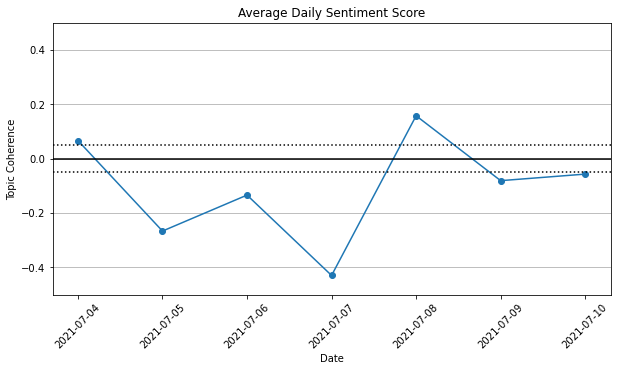

In [24]:
plt.figure(figsize=[10, 5])
plt.plot(sentiment_avg, marker='o')
plt.grid(axis = 'y')
plt.axhline(y = 0.05, color = 'black', linestyle = ':')
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.axhline(y = -0.05, color = 'black', linestyle = ':')
plt.title("Average Daily Sentiment Score")
plt.xticks(rotation = 45)
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Topic Coherence', fontsize = 10)
plt.ylim([-0.5, 0.5])

# LDA Section

# Finding best K

In [25]:
def topic_coherence(model, n_top_words, pair_score):
    coherences = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        coh = 0
        for i in range(len(top_features_ind)):
            for j in range(i):
                coh += pair_score[top_features_ind[i], top_features_ind[j]]
        coherences.append(coh)
    return coherences

## Positive Data-set

In [26]:
# the vectorizer object will be used to transform text to vector form
vectorizer_pos = CountVectorizer(max_df=0.95, min_df=2)

# apply transformation
tf_pos = vectorizer_pos.fit_transform(this_data_pos['clean_text']) #.toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_pos_feature_names = vectorizer_pos.get_feature_names()

# check dimensions
print(tf_pos.shape)

(17, 6)


In [27]:
Dwi = np.array(np.sum(tf_pos > 0, axis=0))[0]

W_bin = tf_pos
W_bin[W_bin > 0] = 1
Dwi_wj = W_bin.T @ W_bin

score_umass_pos = np.log((Dwi_wj.toarray() + 1)/ Dwi)

In [28]:
t0 = time.time()
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]
pos_topic_cohs = []
for k in ks:
    print(f'running k = {k}')
    this_coh = []
    this_model_pos = LatentDirichletAllocation(n_components=k, random_state=0)
    this_model_pos.fit(tf_pos)
    this_coh.append(np.median(topic_coherence(this_model_pos, 10, score_umass_pos)))
    pos_topic_cohs.append(this_coh)
    
t1 = time.time()

total = t1-t0
print(total, 'seconds')

running k = 2
running k = 3
running k = 4
running k = 5
running k = 6
running k = 7
running k = 8
running k = 9
running k = 10
0.17313694953918457 seconds


In [29]:
pos_topic_cohs

[[-7.624618986159399],
 [-7.6246189861593985],
 [-7.827351540213481],
 [-7.6246189861593985],
 [-8.030084094267565],
 [-8.435549202375729],
 [-8.435549202375729],
 [-8.435549202375729],
 [-8.030084094267565]]

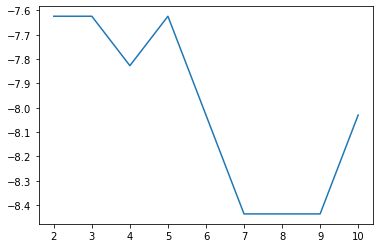

In [30]:
plt.plot(ks, pos_topic_cohs)

## Negative Data-set

In [31]:
# the vectorizer object will be used to transform text to vector form
vectorizer_neg = CountVectorizer(max_df=0.95, min_df=2)

# apply transformation
tf_neg = vectorizer_neg.fit_transform(this_data_neg['clean_text']) #.toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_neg_feature_names = vectorizer_neg.get_feature_names()

# check dimensions
print(tf_neg.shape)

(57, 54)


In [32]:
Dwi_neg = np.array(np.sum(tf_neg > 0, axis=0))[0]

W_bin_neg = tf_neg
W_bin_neg[W_bin_neg > 0] = 1
Dwi_wj_neg = W_bin_neg.T @ W_bin_neg

score_umass_neg = np.log((Dwi_wj_neg.toarray() + 1)/ Dwi_neg)

In [33]:
t0 = time.time()
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]
neg_topic_cohs = []
for k in ks:
    print(f'running k = {k}')
    this_coh = []
    this_model_neg = LatentDirichletAllocation(n_components=k, random_state=0)
    this_model_neg.fit(tf_neg)
    this_coh.append(np.median(topic_coherence(this_model_neg, 10, score_umass_neg)))
    neg_topic_cohs.append(this_coh)
    
t1 = time.time()

total = t1-t0
print(total, 'seconds')

running k = 2
running k = 3
running k = 4
running k = 5
running k = 6
running k = 7
running k = 8
running k = 9
running k = 10
0.5887980461120605 seconds


In [34]:
neg_topic_cohs

[[-39.59649605330824],
 [-5.505586101669931],
 [-20.063133279504882],
 [-5.505586101669931],
 [-20.087717202860052],
 [-20.27898840565686],
 [-21.764505540948356],
 [-17.676298720212486],
 [-30.968868699496127]]

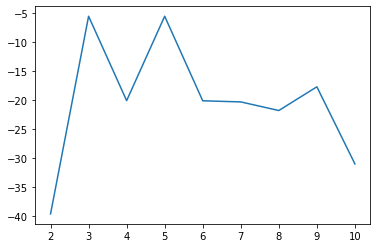

In [35]:
plt.plot(ks, neg_topic_cohs)

## Neutral Data-set

In [36]:
# the vectorizer object will be used to transform text to vector form
vectorizer_neu = CountVectorizer(max_df=0.95, min_df=2)

# apply transformation
tf_neu = vectorizer_neu.fit_transform(this_data_neu['clean_text']) #.toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_neu_feature_names = vectorizer_neu.get_feature_names()

# check dimensions
print(tf_neu.shape)

(41, 32)


In [37]:
Dwi_neu = np.array(np.sum(tf_neu > 0, axis=0))[0]

W_bin_neu = tf_neu
W_bin_neu[W_bin_neu > 0] = 1
Dwi_wj_neu = W_bin_neu.T @ W_bin_neu

score_umass_neu = np.log((Dwi_wj_neu.toarray() + 1)/ Dwi_neu)

In [38]:
t0 = time.time()
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]
neu_topic_cohs = []
for k in ks:
    print(f'running k = {k}')
    this_coh = []
    this_model_neu = LatentDirichletAllocation(n_components=k, random_state=0)
    this_model_neu.fit(tf_neu)
    this_coh.append(np.median(topic_coherence(this_model_neu, 10, score_umass_neu)))
    neu_topic_cohs.append(this_coh)
    
t1 = time.time()

total = t1-t0
print(total, 'seconds')

running k = 2
running k = 3
running k = 4
running k = 5
running k = 6
running k = 7
running k = 8
running k = 9
running k = 10
0.5028610229492188 seconds


In [39]:
neu_topic_cohs

[[-3.2941250591975653],
 [-5.210726584178398],
 [-16.778252386602766],
 [-21.424834367038727],
 [-24.951897252783944],
 [-20.459753470995135],
 [-18.635773865309364],
 [-17.806659827007596],
 [-17.113512646447646]]

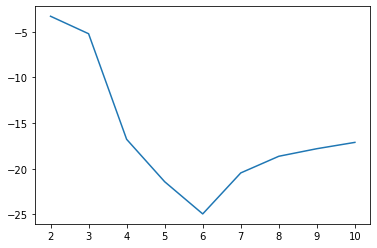

In [40]:
plt.plot(ks, neu_topic_cohs)

# Running on best k

Text(0, 0.5, 'Topic Coherence')

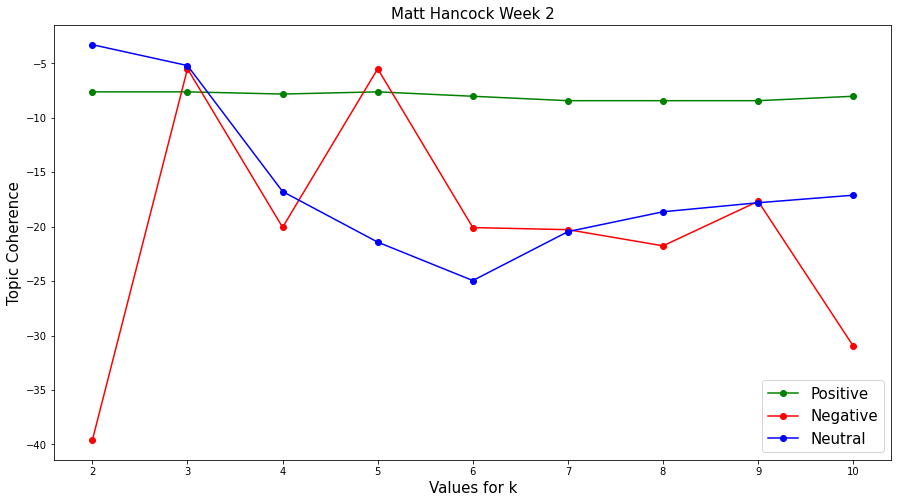

In [41]:
plt.figure(figsize=[15, 8])
plt.title("Matt Hancock Week 2", fontsize = 15)
plt.plot(ks, pos_topic_cohs, label = 'Positive', marker='o', color = 'g')
plt.plot(ks, neg_topic_cohs, label = 'Negative', marker='o', color = 'r')
plt.plot(ks, neu_topic_cohs, label = 'Neutral', marker='o', color = 'b')
plt.legend(prop={"size":15})
plt.xlabel('Values for k', fontsize = 15)
plt.ylabel('Topic Coherence', fontsize = 15)

In [42]:
def plot_top_words(model, feature_names, n_top_words, title):
    """Function to plot topic models"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

## Positive Data-Set

In [43]:
# Choose based on above results
number_of_topics = 2
n_top_words = 10

In [44]:
# model
model_pos = LatentDirichletAllocation(n_components=number_of_topics, random_state=0) # random state for reproducibility

# Fit data to model
t0 = time.time()
model_pos.fit(tf_pos)
t1 = time.time()

total = t1-t0
print(total, 'seconds') #note: 615.2014217376709 seconds

0.019863128662109375 seconds


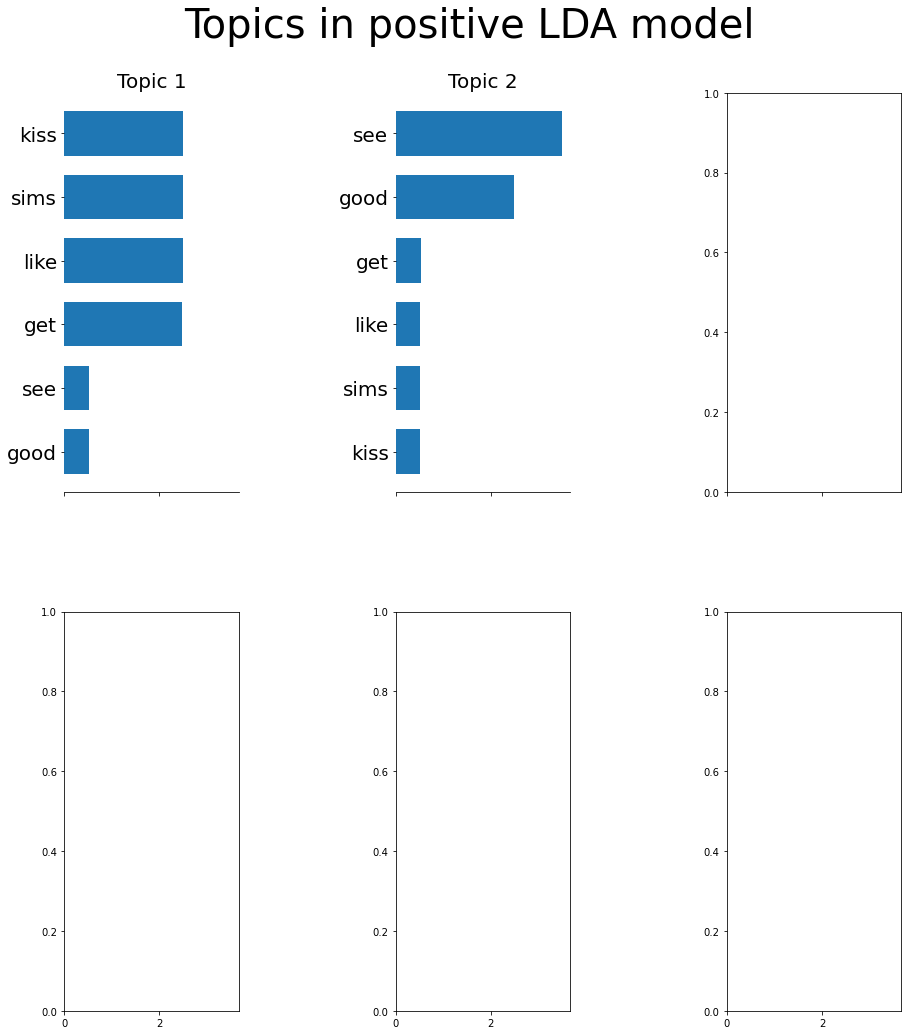

In [45]:
# Names of words 
plot_top_words(model_pos, tf_pos_feature_names, n_top_words, 'Topics in positive LDA model')

## Negative Data-Set

In [46]:
# Choose based on above results
number_of_topics = 3
n_top_words = 10

In [47]:
# model
model_neg = LatentDirichletAllocation(n_components=number_of_topics, random_state=0) # random state for reproducibility

# Fit data to model
t0 = time.time()
model_neg.fit(tf_neg)
t1 = time.time()

total = t1-t0
print(total, 'seconds') #note: 615.2014217376709 seconds

0.07284998893737793 seconds


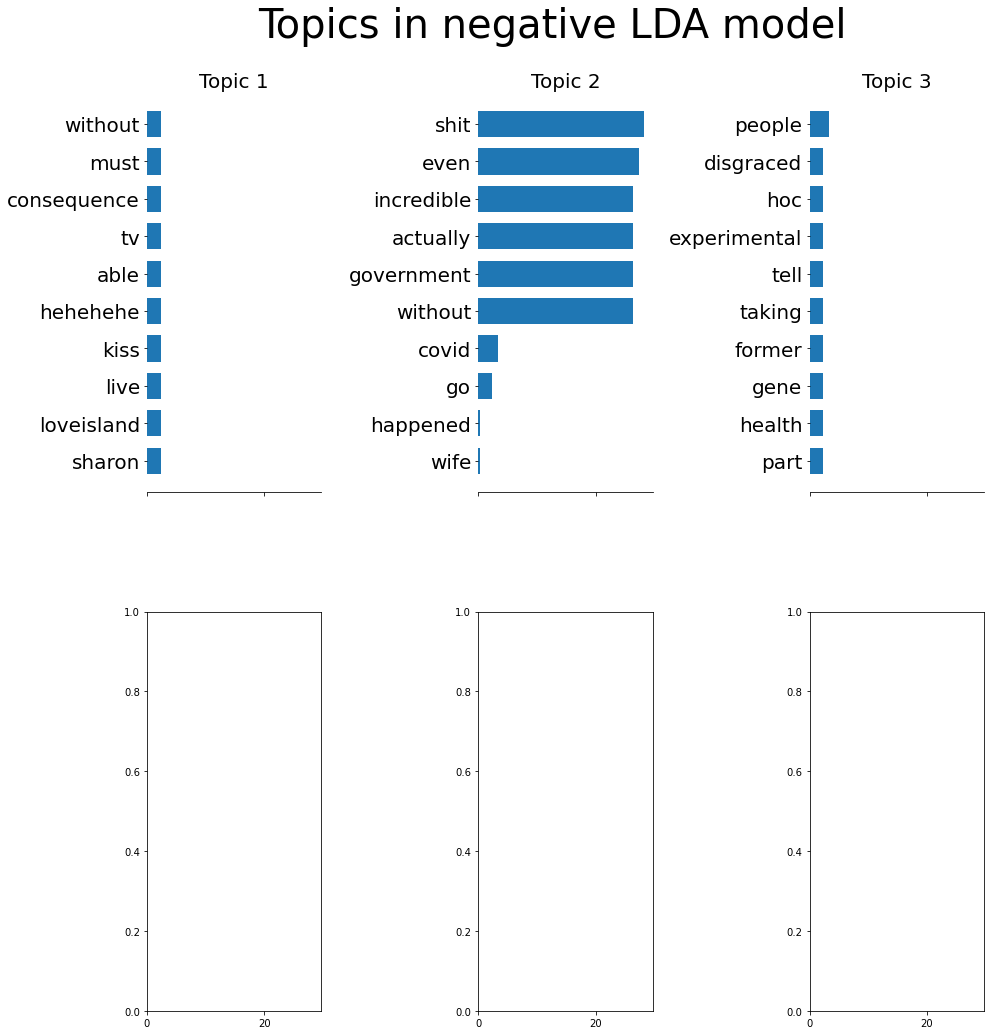

In [48]:
# Names of words 
plot_top_words(model_neg, tf_neg_feature_names, n_top_words, 'Topics in negative LDA model')

## Neutral Data-Set

In [49]:
# Choose based on above results
number_of_topics = 2
n_top_words = 10

In [50]:
# model
model_neu = LatentDirichletAllocation(n_components=number_of_topics, random_state=0) # random state for reproducibility

# Fit data to model
t0 = time.time()
model_neu.fit(tf_neu)
t1 = time.time()

total = t1-t0
print(total, 'seconds') #note: 615.2014217376709 seconds

0.07863116264343262 seconds


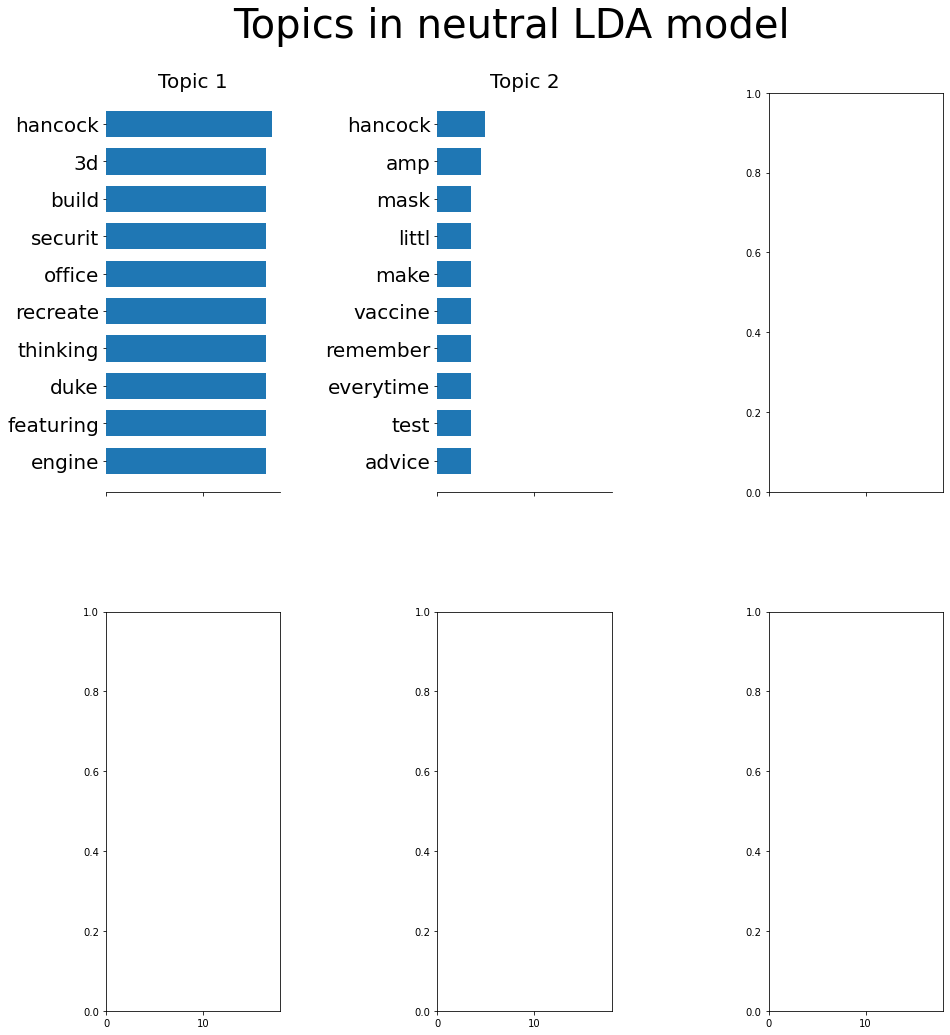

In [51]:
# Names of words 
plot_top_words(model_neu, tf_neu_feature_names, n_top_words, 'Topics in neutral LDA model')